<a href="https://colab.research.google.com/github/Nativ-shalom/streaming-episode-prediction/blob/main/Binge_Watching_Project_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎬 Predicting Binge Watching Based on Auto-Play Timing

This project explores whether the delay between episodes (auto-play delay) affects the likelihood that a user will continue watching the next episode.
- We'll create synthetic data
- Perform EDA (Exploratory Data Analysis)
- Build classification models
- Evaluate performance and draw insights

In [2]:
# 📦 create sintetic Data
import numpy as np
import pandas as pd
import random

np.random.seed(42)
n = 500

def simulate_user():
    auto_play_delay = np.random.choice([0, 2, 5, 10, 20, 30, 60])
    episode_length = np.random.randint(20, 61)
    finished_percent = round(np.random.uniform(0.4, 1.0), 2)
    hour_of_day = np.random.randint(0, 24)
    day_of_week = np.random.choice(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    device_type = np.random.choice(['TV', 'Mobile', 'Tablet', 'PC'])

    likely_to_continue = (
        auto_play_delay <= 5 and
        finished_percent >= 0.85 and
        (hour_of_day >= 20 or hour_of_day <= 1)
    )

    continued = int(likely_to_continue or np.random.rand() < 0.2)
    return {
        'auto_play_delay': auto_play_delay,
        'episode_length': episode_length,
        'finished_percent': finished_percent,
        'hour_of_day': hour_of_day,
        'day_of_week': day_of_week,
        'device_type': device_type,
        'continued': continued
    }

data = [simulate_user() for _ in range(n)]
df = pd.DataFrame(data)
df.head()

,auto_play_delay,episode_length,finished_percent,hour_of_day,day_of_week,device_type,continued
0,60,48,0.51,7,Fri,TV,1
1,5,42,0.43,23,Fri,PC,1
2,5,41,0.43,23,Thu,Mobile,0
3,10,40,0.77,21,Fri,PC,1
4,5,47,0.98,14,Sat,Mobile,0


## 📊 ניתוח ראשוני (EDA)

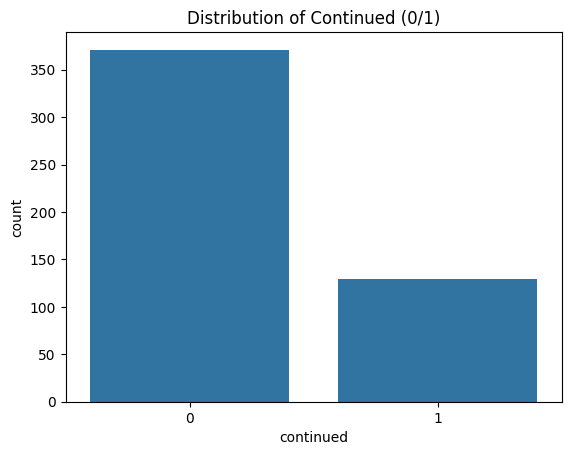

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='continued', data=df)
plt.title('Distribution of Continued (0/1)')
plt.show()

## 🤖 בניית מודל ראשוני

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

df_encoded = pd.get_dummies(df, columns=['device_type', 'day_of_week'], drop_first=True)
X = df_encoded.drop(columns=['continued'])
y = df_encoded['continued']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86       113
           1       1.00      0.03      0.05        37

    accuracy                           0.76       150
   macro avg       0.88      0.51      0.46       150
weighted avg       0.82      0.76      0.66       150



In [6]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['continued'] == 0]
df_minority = df[df['continued'] == 1]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,     # sample with replacement
    n_samples=len(df_majority),  # match number of majority
    random_state=42
)

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Re-encode categorical columns
df_encoded_bal = pd.get_dummies(df_balanced, columns=['device_type', 'day_of_week'], drop_first=True)

# Split into train/test
X_bal = df_encoded_bal.drop(columns=['continued'])
y_bal = df_encoded_bal['continued']
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)

# Train logistic regression on balanced data
clf_bal = LogisticRegression(max_iter=1000)
clf_bal.fit(X_train_bal, y_train_bal)
y_pred_bal = clf_bal.predict(X_test_bal)

# Show results
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_bal, y_pred_bal))
print(confusion_matrix(y_test_bal, y_pred_bal))


              precision    recall  f1-score   support

           0       0.57      0.50      0.53       116
           1       0.52      0.60      0.56       107

    accuracy                           0.55       223
   macro avg       0.55      0.55      0.55       223
weighted avg       0.55      0.55      0.55       223

[[58 58]
 [43 64]]


In [7]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_bal, y_train_bal)

# Predict
y_pred_rf = rf_clf.predict(X_test_bal)

# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix

print("Random Forest Results:\n")
print(classification_report(y_test_bal, y_pred_rf))
print(confusion_matrix(y_test_bal, y_pred_rf))


Random Forest Results:

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       116
           1       0.89      0.82      0.85       107

    accuracy                           0.87       223
   macro avg       0.87      0.86      0.86       223
weighted avg       0.87      0.87      0.87       223

[[105  11]
 [ 19  88]]


<ipython-input-8-2bd4df795fcb>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df.head(10), palette='viridis')


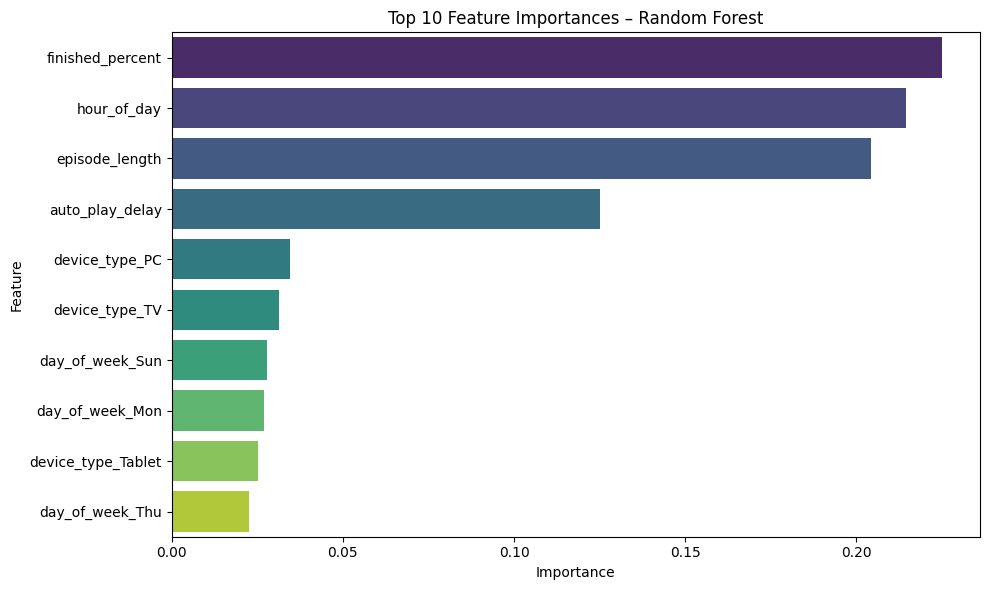

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# get each fiture importance
importances = rf_clf.feature_importances_
feature_names = X_train_bal.columns

# create a table
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#  plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances – Random Forest')
plt.tight_layout()
plt.show()


In [9]:
feat_df.to_csv("feature_importance_summary.csv", index=False)


##  Summary & Key Insights

In this project, we built a machine learning classifier to predict whether users will continue watching the next episode on a streaming platform.

Using a balanced dataset and a Random Forest model, we achieved **87% accuracy**, with strong **recall and precision** across both continuation and dropout cases.

The feature importance analysis revealed several key behavioral drivers:

- **`finished_percent`** was the most important factor: users who finished more of the current episode were significantly more likely to continue.
- **`hour_of_day`** had high impact, indicating that users watching during **evening hours** were more likely to keep watching.
- **`episode_length`** and **`auto_play_delay`** also played major roles: shorter episodes and faster auto-play transitions increased continuation likelihood.
- Device type and day of the week had moderate effects. For example, users on **PCs and TVs** were more likely to continue than those on tablets, and **Sunday/Monday** showed higher engagement.

###  Key takeaway:
To improve viewer retention, streaming platforms should:
- Aim to keep auto-play delay **below 7 seconds**
- Optimize for evening-time engagement
- Encourage users to finish episodes (e.g., through UI nudges)
- Consider device-specific UX adjustments for tablets

The model provides interpretable and actionable signals that could be used to personalize the user experience in real time.
